In [1]:
import pickle
import CO2_Dataset_Preparation
import CO2_functions
import CO2_Processing
from CO2_Dataset_Preparation import *
from CO2_functions import * 
from CO2_Processing import *

import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)
importlib.reload(CO2_Dataset_Preparation)

from CO2_Dataset_Preparation import *
from CO2_functions import *
from CO2_Processing import *

%load_ext rpy2.ipython

In [2]:
data = Dataset('../CO2_Data_Final',2,logfile = None)
data._preprocess()

Retrieving data for 2019-08-28
Retrieving data for 2019-08-29
Retrieving data for 2019-08-30
Retrieving data for 2019-08-31
Retrieving data for 2019-09-01
Retrieving data for 2019-09-02
Retrieving data for 2019-09-03
Retrieving data for 2019-09-04
Retrieving data for 2019-09-05
Retrieving data for 2019-09-06
Retrieving data for 2019-09-07
Retrieving data for 2019-09-08
Retrieving data for 2019-09-09
Retrieving data for 2019-09-10
Retrieving data for 2019-09-11
Retrieving data for 2019-09-12
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero
Combining vent data
Adding Mass Flow
Hard Filtering Multi
Binding CO2_1 between 390 and 600
Binding CO2_2 between 390 and 600
Binding CO2_3 between 390 and 600
Binding Rotations between 0 and 20
Binding Wind_Velocity between 0 and 20
Median Filtering Multi
Filtering Temp with window 100 and sigma 5


In [3]:
import copy
data1 = copy.deepcopy(data)

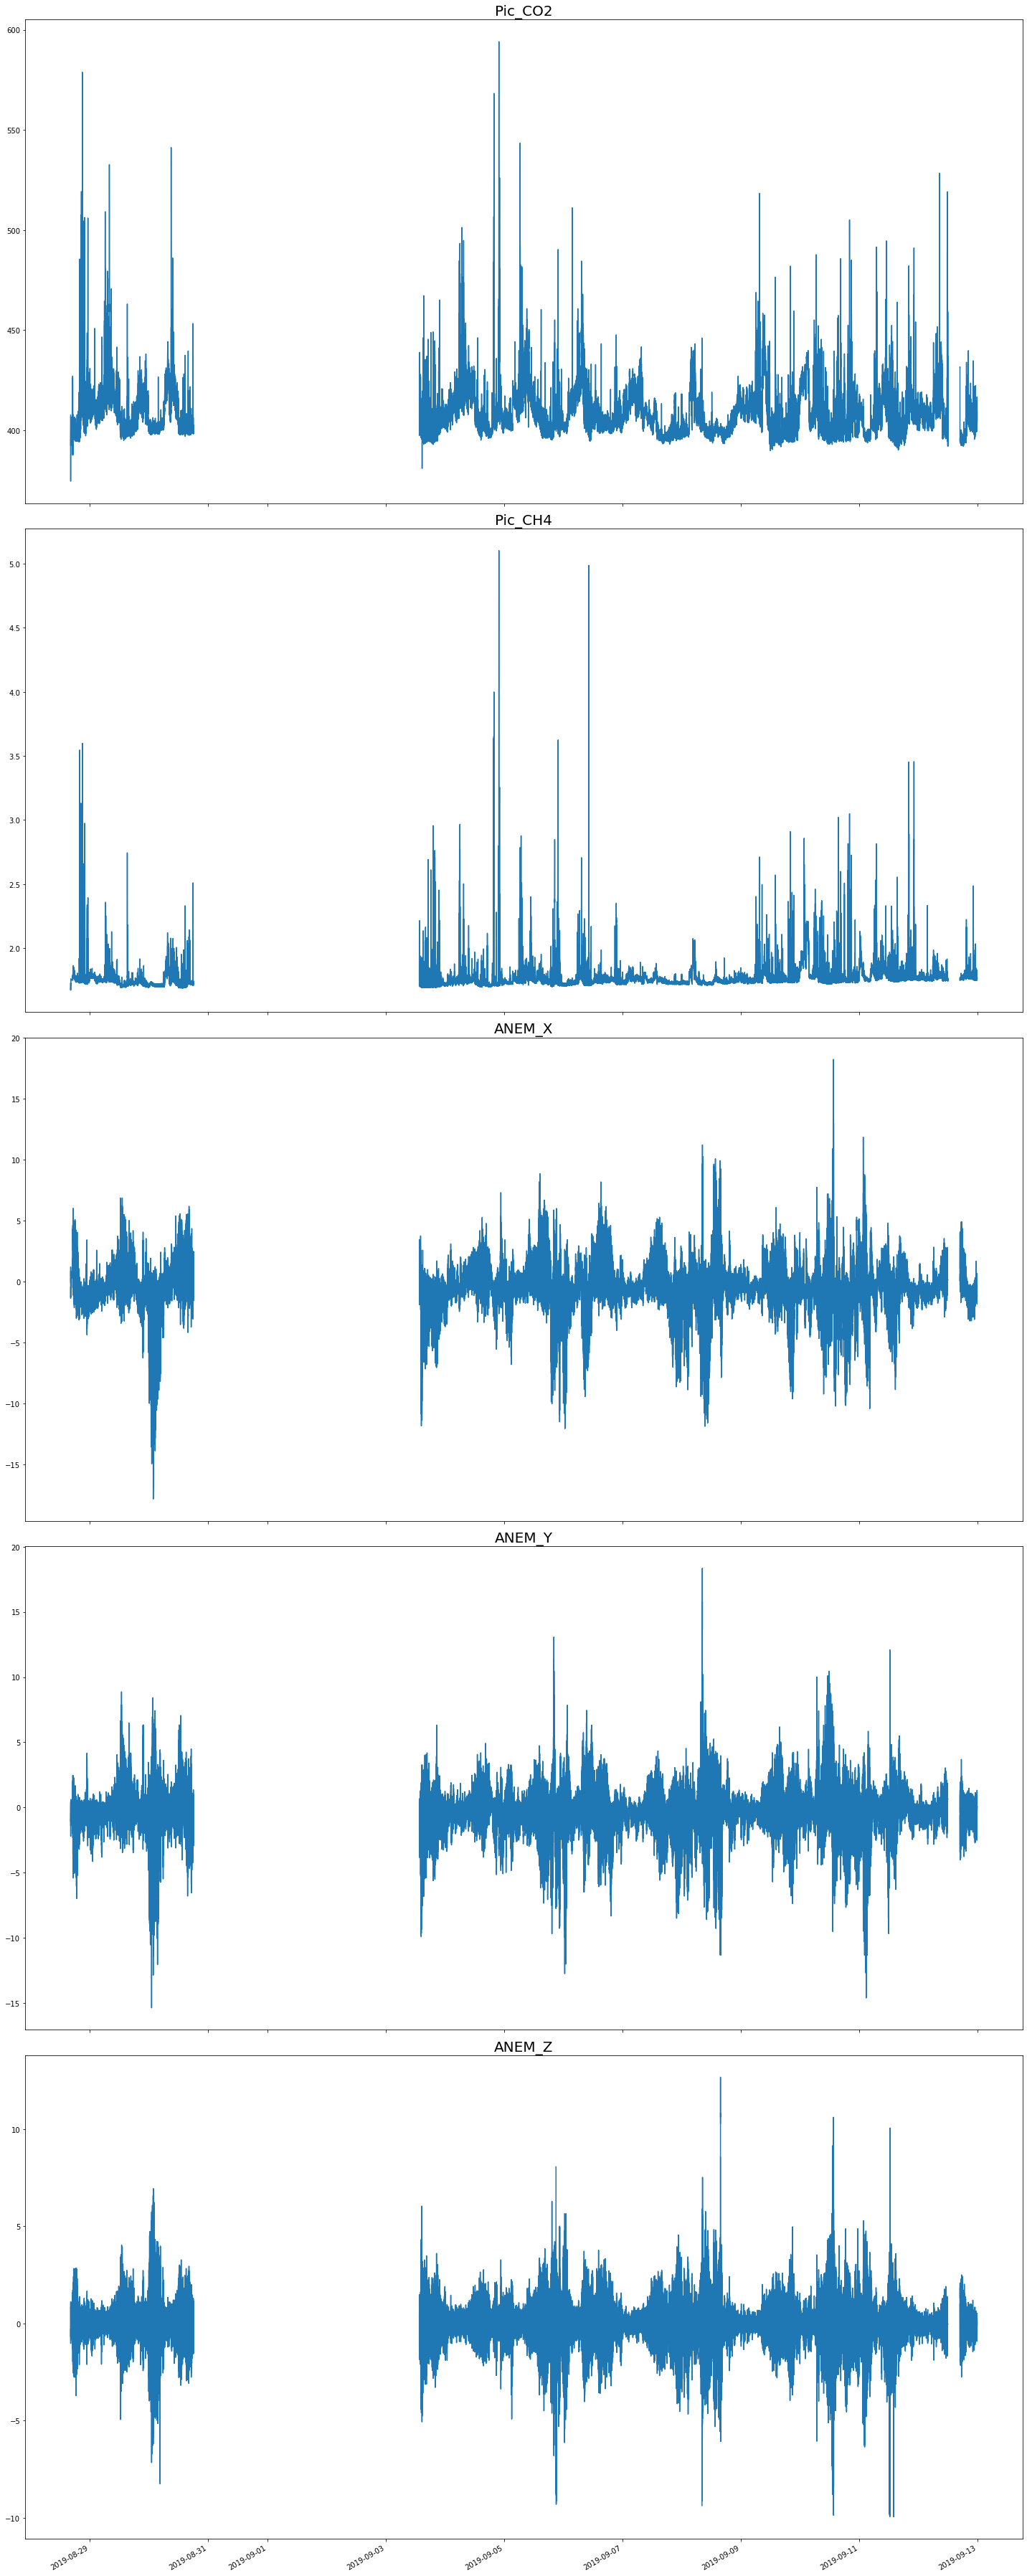

Is this an acceptable range? y


In [7]:
pic = [[data1.data['Picarro'],'Corrected_DT','Pic_CO2'],\
       [data1.data['Picarro'],'Corrected_DT','Pic_CH4'],\
       [data1.data['Picarro'],'Corrected_DT','ANEM_X'],\
       [data1.data['Picarro'],'Corrected_DT','ANEM_Y'],\
       [data1.data['Picarro'],'Corrected_DT','ANEM_Z']]

multi = [[data1.data['Multi'],'Corrected_DT','CO2_1'],
         [data1.data['Multi'],'Corrected_DT','CO2_2'],\
         [data1.data['Multi'],'Corrected_DT','CO2_3'],\
         [data1.data['Multi'],'Corrected_DT','Temp'],\
         [data1.data['Multi'],'Corrected_DT','Rotations'],\
         [data1.data['Multi'],'Corrected_DT','Wind_Velocity'],\
         [data1.data['Multi'],'Corrected_DT','Wind_Direction']]

vent = [[data1.data['Vent_Mass'],'Corrected_DT','m_dot']]

x=plot_refinement_all(pic,'separate')

# --------------------
# Baseline Testing
# --------------------

In [ ]:
data1 = data
clip_dict = data1.data
for key in data1.data:
    clip_dict[key] = clip_dict[key].loc[(clip_dict[key].index >'2019-11-13 00:00:00')&(clip_dict[key].index <'2019-11-14 00:00:00')]

In [ ]:
def _add_excess_CO2(data_dict,df_key_array):
    for key in df_key_array:
        print(f"Excess processing {key}")
        df = data_dict[key]
        if key == 'Picarro':
            cols_for_excess = ['Pic_CO2','Pic_CH4']
            roll = 1000
        elif key == 'Multi':
            cols_for_excess = ['CO2_1','CO2_2','CO2_3']
            roll=100
        for col in cols_for_excess:
            print(f"Adding excess for {col}")
            print(roll)
            df[f'std_{col}'] = df[col].interpolate(limit=10).rolling(roll,center=True).std()
            df[f'mean_{col}'] = df[col].interpolate(limit=10).rolling(roll,center=True).mean()
            df[f'min_{col}'] =  df[col].interpolate(limit=10).rolling(roll,center=True).min()
            df[f'min_roll_{col}'] =  df[f'min_{col}'].rolling(roll*50,center=True).mean()
            df[f'baseline_{col}'] = df.apply(lambda row: row[f'mean_{col}']+(-2.326)*row[f'std_{col}'],axis=1)
            df[f'baseline_roll_{col}']= df[f'baseline_{col}'].rolling(roll,center=True).mean()
            df[f'Excess_{col}']= df.apply(lambda row: row[col]-row[f'baseline_roll_{col}'],axis=1)
        #df = df.drop(['std','mean','baseline'],axis=1)
        data_dict[key] = df
    return data_dict
d = _add_excess_CO2(clip_dict,['Multi'])

In [ ]:
pic_new = [[data1.data['Picarro'],'Corrected_DT','Pic_CO2'],\
       [data1.data['Picarro'],'Corrected_DT','Pic_CH4'],\
       [data1.data['Picarro'],'Corrected_DT','ANEM_X'],\
       [data1.data['Picarro'],'Corrected_DT','ANEM_Y'],\
       [data1.data['Picarro'],'Corrected_DT','ANEM_Z']]

multi_orig = [[data.data['Multi'],'Corrected_DT','CO2_1'],\
        [data.data['Multi'],'Corrected_DT','CO2_2'],\
        [data.data['Multi'],'Corrected_DT','CO2_3'],\
        [data.data['Multi'],'Corrected_DT','Temp'],\
        [data.data['Multi'],'Corrected_DT','Wind_Velocity']\
        ]

multi_new = [[data1.data['Multi'],'Corrected_DT','CO2_1'],\
        [data1.data['Multi'],'Corrected_DT','CO2_2'],\
        [data1.data['Multi'],'Corrected_DT','CO2_3'],\
        [data1.data['Multi'],'Corrected_DT','Temp'],\
        [data1.data['Multi'],'Corrected_DT','Wind_Velocity']\
        ]

key = 'Multi'
col = 'CO2_1'
testdf = plot_refinement_all([[d[key],'Corrected_DT',col],
                              [d[key],'Corrected_DT',f'min_roll_{col}']]\
                             ,'stack')

# -----------------------------
# R
# -----------------------------

In [ ]:
pic_10 = data.data['Picarro'].resample("10S").agg(dict(Pic_CO2='max',Pic_CH4='max',ANEM_Y='mean',ANEM_X='mean',ANEM_Z='mean',Pic_Loc = 'last'))
pic_10 = wind_add(pic_10,'ANEM_X','ANEM_Y')

import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(pic_10)

In [ ]:
pic_10

In [ ]:
%%R -i r_df
.libPaths()
write.csv(r_df,file='Openair/data_PN2.Rdat')

<img src="Openair/data.jpg">

# ---------------------------------
# DASH/PLOTLY
# ---------------------------------

In [ ]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np
from scipy import special

py.offline.init_notebook_mode(connected=True)

In [ ]:
x = np.linspace(0,np.pi,1000)


layout = go.Layout(
    title = 'SIM',
    yaxis = dict(
        title = 'volts'
    ),
    xaxis = dict(
        title = 'ns'
    )
)

trace1 = go.Scatter(
    x = x,
    y = np.sin(x),
    mode = 'lines',
    name = 'sin(x)',
    line = dict(
        shape = 'spline'
    )
)

fig = go.Figure(data=[trace1],layout=layout)
py.offline.iplot(fig)

In [ ]:
import nbformat
nbformat.__version__